In [23]:
import sys
sys.path.append('/ossfs/workspace/jd_paper/mydata/')
sys.path.append('/ossfs/workspace/jd_paper/HGT-semi/')
import scipy.io
import urllib.request
import dgl
import math
import numpy as np
import pandas as pd
from model_orig import *
import torch
from data_loader import data_loader
from utils.data import load_data
from utils.pytorchtools import EarlyStopping
from utils.tools import evaluate_results_nc
import argparse
import time

def sp_to_spt(mat):
    coo = mat.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))


def mat2tensor(mat):
    print('mat len>>>>>>>',mat)
    if type(mat) is np.ndarray:
        return torch.from_numpy(mat).type(torch.FloatTensor)
    return sp_to_spt(mat)

def build_heterograph(args):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    print('loading data >>>>>>>>>>>>>>>>>>>>>')
    dataset = data_loader('/ossfs/workspace/jd_paper/mydata/'+args.dataset)
    edge_dict = {}

    for i, meta_path in dataset.links['meta'].items():
#         print('ltypr>>>>>>>',i)
#         print('ltype count>>>>>>>',dataset.links['count'][i])
        edge_dict[(str(meta_path[0]), str(meta_path[0]) + '_' + str(meta_path[1]), str(meta_path[1]))] = (torch.tensor(dataset.links['data'][i].tocoo().row - dataset.nodes['shift'][meta_path[0]]), torch.tensor(dataset.links['data'][i].tocoo().col - dataset.nodes['shift'][meta_path[1]]))
    print('edge_dict>>>>>>>',edge_dict)
    
    node_count = {}
    for i, count in dataset.nodes['count'].items():
        node_count[str(i)] = count
        print(i, node_count)

    print('building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>')
    G = dgl.heterograph(edge_dict, num_nodes_dict = node_count, device=device)
    """
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = dataset.nodes['attr'][ntype]
        # print(G.nodes['attr'][ntype].shape)
    """

    G.node_dict = {}
    G.edge_dict = {}
    for ntype in G.ntypes:
        G.node_dict[ntype] = len(G.node_dict)
    for etype in G.etypes:
        G.edge_dict[etype] = len(G.edge_dict)
        G.edges[etype].data['id'] = torch.ones(G.number_of_edges(etype), dtype=torch.long).to(device) * G.edge_dict[etype] 
        print('number_of_edges>>>>>>>>',etype,'**',G.number_of_edges(etype))
    return G,dataset

def run_model_DBLP(args, G, dataset, rep):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    feats_type = args.feats_type
    features_list, adjM, labels, train_val_test_idx, dl = load_data(args.dataset)
    features_list = [mat2tensor(features).to(device) for features in features_list]
    print('labels>>>',dl.labels_train['num_classes'])

    if feats_type == 0:
        in_dims = [features.shape[1] for features in features_list]
    elif feats_type == 1 or feats_type == 5:
        save = 0 if feats_type == 1 else 2
        in_dims = []#[features_list[0].shape[1]] + [10] * (len(features_list) - 1)
        for i in range(0, len(features_list)):
            if i == save:
                in_dims.append(features_list[i].shape[1])
            else:
                in_dims.append(10)
                features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
    elif feats_type == 2 or feats_type == 4:
        save = feats_type - 2
        in_dims = [features.shape[0] for features in features_list]
        for i in range(0, len(features_list)):
            if i == save:
                in_dims[i] = features_list[i].shape[1]
                continue
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    elif feats_type == 3:
        in_dims = [features.shape[0] for features in features_list]
        for i in range(len(features_list)):
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)

    ## 添加图特征
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = features_list[int(ntype)]#.to(device)
    labels = torch.LongTensor(labels).to(device)
    train_idx = train_val_test_idx['train_idx']
    train_idx = np.sort(train_idx)
    val_idx = train_val_test_idx['val_idx']
    val_idx = np.sort(val_idx)
    test_idx = train_val_test_idx['test_idx']
    test_idx = np.sort(test_idx)
    unlabel_idx = train_val_test_idx['unlabel_idx']
    unlabel_idx = np.sort(unlabel_idx)
    
    ## kk
    is_label = torch.ones(len(G.nodes['0'].data['inp'])).view(-1,1)
    is_label[unlabel_idx]=0
    for ntype in G.ntypes:
        if ntype == '0':
            G.nodes[ntype].data['is_label'] = is_label.to(device)
        else:
            G.nodes[ntype].data['is_label'] = torch.zeros(len(G.nodes[ntype].data['inp'])).view(-1,1).to(device)
    ## kk

    print(len(train_idx), len(test_idx), len(val_idx), len(unlabel_idx))
    model = HGT(G, n_inps=in_dims, n_hid=args.hidden_dim, n_out=labels.max().item()+1, n_layers=args.num_layers, n_heads=args.num_heads, unlabel_idx=unlabel_idx, use_norm = args.use_norm).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=args.weight_decay)#, lr=args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.schedule_step, max_lr = 1e-3, pct_start=0.05)

    early_stopping = EarlyStopping(patience=args.patience, verbose=True, save_path='/ossfs/workspace/jd_paper/result/checkpoint_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep))
    train_step = 0
    for epoch in range(args.epoch):
        with torch.autograd.set_detect_anomaly(True):
            t_start = time.time()
            model.train()
            # , embeddings2 
            logits1, embeddings1 = model(G, '0')
            print('cross_entropy>>>>>>>> ',F.cross_entropy(logits1[train_idx], labels[train_idx].to(device)))
            train_loss = F.cross_entropy(logits1[train_idx], labels[train_idx].to(device))
            pred = logits1.argmax(1)
            train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
        

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            train_step += 1
            scheduler.step(train_step)
            t_end = time.time()
        print('Epoch {:05d} | Train_Loss: {:.4f} | Train_acc: {:.4f} |Time: {:.4f}'.format(epoch, train_loss.item(), train_acc.item(), t_end-t_start))
        t_start = time.time()
        model.eval()
        with torch.no_grad():
            logits1, val_embeddings1 = model(G, '0')
            
            val_loss = F.cross_entropy(logits1[val_idx], labels[val_idx])
            pred = logits1.cpu().numpy().argmax(axis=1)
        val_acc   = (pred[val_idx] == labels[val_idx].cpu().numpy()).mean()
        test_acc  = (pred[test_idx] == labels[test_idx].cpu().numpy()).mean()
        test_pred_ = pred[test_idx]
        print('val_acc>>>>>>',val_acc)
        
        t_end = time.time()
        print('Epoch {:05d} | Val_Loss {:.4f} | Val_acc {:.4f} | Test_acc {:.4f} | Time(s) {:.4f}'.format(
            epoch, val_loss.item(), val_acc.item(), test_acc.item(), t_end - t_start))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Early stopping!')
            return model,test_idx,dataset,dl 
    return model,test_idx,dataset,dl
  
def inference(args, model, test_idx, dataset, G, rep, dl):
    model.load_state_dict(torch.load('/ossfs/workspace/jd_paper/result/checkpoint_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep)))
    model.eval()
#     test_logits = []
    with torch.no_grad():
        logits, test_embeddings = model(G, '0')
        test_logits = logits[test_idx]
        
        if args.dataset == 'IMDB1':
            pred = test_logits.cpu().numpy()
        else:
            pred = test_logits.cpu().numpy().argmax(axis=1)
        
        onehot = np.eye(dataset.labels_train['num_classes'], dtype=np.int32)
        pred = onehot[pred]
                
        eval_res = dataset.evaluate(pred)
        print(eval_res['micro-f1'], eval_res['macro-f1'])
        
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
                test_embeddings[test_idx].cpu().numpy(), dataset.labels_test['data'][dataset.labels_test['mask']].argmax(axis=1), num_classes=dataset.labels_test['num_classes'])

        return eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std

In [24]:

# if __name__ == '__main__':
ap = argparse.ArgumentParser(description='MRGNN testing for the DBLP dataset')
ap.add_argument('--feats-type', type=int, default=1,
                help='Type of the node features used. ' +
                        '0 - loaded features; ' +
                        '1 - only target node features (zero vec for others); ' +
                        '2 - only target node features (id vec for others); ' +
                        '3 - all id vec. Default is 2;' +
                    '4 - only term features (id vec for others);' + 
                    '5 - only term features (zero vec for others).')
ap.add_argument('--hidden_dim', type=int, default=64, help='Dimension of the node hidden state. Default is 64.')
ap.add_argument('--num_heads', type=int, default=8, help='Number of the attention heads. Default is 8.')
ap.add_argument('--epoch', type=int, default=30, help='Number of epochs.')
ap.add_argument('--patience', type=int, default=30, help='Patience.')
ap.add_argument('--repeat', type=int, default=1, help='Repeat the training and testing for N times. Default is 1.')
ap.add_argument('--num_layers', type=int, default=2) #5
ap.add_argument('--lr', type=float, default=1e-2) #5e-3
ap.add_argument('--dropout', type=float, default=0)
ap.add_argument('--weight-decay', type=float, default=1e-3) #1e-4
ap.add_argument('--slope', type=float, default=0.05)
ap.add_argument('--dataset', type=str, default='ACM')  # Freebase
ap.add_argument('--edge-feats', type=int, default=64)
ap.add_argument('--device', type=int, default=0)
ap.add_argument('--schedule_step', type=int, default=500)
ap.add_argument('--use_norm', type=bool, default=True)
ap.add_argument('--rate', type=float, default=0.2)

args = ap.parse_args(args=[])
g, dataset = build_heterograph(args)

# 4种类型的节点统一编号
# labels_test1 = pd.read_csv("../data/"+args.dataset+"/label.dat.test", sep = "\t", header=None,
#                  names=["node_id","node_name","node_type","label"])

micro,macro = [],[]
svm_macro_f1_lists,svm_micro_f1_lists,nmi_mean_list,nmi_std_list,ari_mean_list,ari_std_list = [],[],[],[],[],[]
for r in range(args.repeat):
    print('running the '+str(r)+' times >>>>>>>>>>>>')
#     model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r, labels_test1)
    model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r)
    eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = inference(args, model, test_idx, dataset, g, r, dl)
    macro.append(eval_res['macro-f1'])
    micro.append(eval_res['micro-f1'])
    svm_macro_f1_lists.append(svm_macro_f1_list)
    svm_micro_f1_lists.append(svm_micro_f1_list)
    nmi_mean_list.append(nmi_mean)
    nmi_std_list.append(nmi_std)
    ari_mean_list.append(ari_mean)
    ari_std_list.append(ari_std)

    
m_macro = np.mean(macro)
std_macro = np.std(macro)
m_micro = np.mean(micro)
std_micro = np.std(micro)
sqrt_n = np.sqrt(len(micro))
print('------------------------------ final result ----------------------------------------')
print('final result macro_f1 >>>>>>>>>> ',m_macro,'+-',1.96*std_macro/sqrt_n)
print('final result micro_f1 >>>>>>>>>> ',m_micro,'+-',1.96*std_micro/sqrt_n)

# print out a summary of the evaluations
svm_macro_f1_lists = np.transpose(np.array(svm_macro_f1_lists), (1, 0, 2))
svm_micro_f1_lists = np.transpose(np.array(svm_micro_f1_lists), (1, 0, 2))
nmi_mean_list = np.array(nmi_mean_list)
nmi_std_list = np.array(nmi_std_list)
ari_mean_list = np.array(ari_mean_list)
ari_std_list = np.array(ari_std_list)
print('----------------------------------------------------------------')
print('SVM tests summary')
print('Macro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    macro_f1[:, 0].mean(), macro_f1[:, 1].mean(), train_size) for macro_f1, train_size in
    zip(svm_macro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('Micro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    micro_f1[:, 0].mean(), micro_f1[:, 1].mean(), train_size) for micro_f1, train_size in
    zip(svm_micro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('K-means tests summary')
print('NMI: {:.6f}~{:.6f}'.format(nmi_mean_list.mean(), nmi_std_list.mean()))
print('ARI: {:.6f}~{:.6f}'.format(ari_mean_list.mean(), ari_std_list.mean()))


loading data >>>>>>>>>>>>>>>>>>>>>
edge_dict>>>>>>> {('0', '0_1', '1'): (tensor([   0,    0,    0,  ..., 3024, 3024, 3024], dtype=torch.int32), tensor([1674, 1925, 4504,  ...,  489, 2300, 4786], dtype=torch.int32)), ('1', '1_0', '0'): (tensor([   0,    0,    1,  ..., 5956, 5957, 5958], dtype=torch.int32), tensor([ 364, 1784, 1206,  ..., 2899, 2882, 1936], dtype=torch.int32)), ('0', '0_2', '2'): (tensor([   0,    1,    2,  ..., 3022, 3023, 3024], dtype=torch.int32), tensor([50, 35, 34,  ..., 40, 34, 34], dtype=torch.int32)), ('2', '2_0', '0'): (tensor([ 0,  1,  2,  ..., 55, 55, 55], dtype=torch.int32), tensor([1667,   80, 2245,  ..., 2661, 2668, 2671], dtype=torch.int32)), ('0', '0_0', '0'): (tensor([   0,    0,    1,  ..., 3019, 3021, 3021], dtype=torch.int32), tensor([ 179, 2697, 2523,  ..., 2547, 1001, 1110], dtype=torch.int32))}
0 {'0': 3025}
1 {'0': 3025, '1': 5959}
2 {'0': 3025, '1': 5959, '2': 56}
building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>
number_of_edges>>>>>>>> 0_0 ** 5343


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val_acc>>>>>> 0.35911602209944754
Epoch 00000 | Val_Loss 1.3000 | Val_acc 0.3591 | Test_acc 0.3477 | Time(s) 0.1655
Validation loss decreased (inf --> 1.299951).  Saving model ...
cross_entropy>>>>>>>>  tensor(1.3129, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 00001 | Train_Loss: 1.3129 | Train_acc: 0.3370 |Time: 0.7723
val_acc>>>>>> 0.35911602209944754
Epoch 00001 | Val_Loss 1.2755 | Val_acc 0.3591 | Test_acc 0.3472 | Time(s) 0.1401
Validation loss decreased (1.299951 --> 1.275527).  Saving model ...
cross_entropy>>>>>>>>  tensor(1.2919, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 00002 | Train_Loss: 1.2919 | Train_acc: 0.3453 |Time: 0.6780
val_acc>>>>>> 0.35911602209944754
Epoch 00002 | Val_Loss 1.2469 | Val_acc 0.3591 | Test_acc 0.3491 | Time(s) 0.1396
Validation loss decreased (1.275527 --> 1.246936).  Saving model ...
cross_entropy>>>>>>>>  tensor(1.2439, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 00003 | Train_Loss: 1.2439 | Train_acc: 0.3425 |Time: 0.6500
val

In [ ]:
1

In [14]:

import pandas as pd
from data_loader import gen_file_for_evaluate
data = 'DBLP'

for i in range(5):
    df = pd.read_csv('../result/'+data+'_'+str(i)+'.txt', sep='\t', names=["node_id","node_name","node_type","label"])
    df[['label']].to_csv('../result1/'+data+'_'+str(i)+'.txt', sep='\t',index=False, header = False)

In [4]:
np.random.shuffle([1,2,3,4])

In [25]:
def inference(args, model, test_idx, dataset, G, rep, dl):
    model.load_state_dict(torch.load('/ossfs/workspace/jd_paper/result/checkpoint_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, 0)))
    model.eval()
#     test_logits = []
    with torch.no_grad():
        logits, test_embeddings = model(G, '0')
        test_logits = logits[test_idx]
        
        if args.dataset == 'IMDB1':
            pred = test_logits.cpu().numpy()
        else:
            pred = test_logits.cpu().numpy().argmax(axis=1)
        
        onehot = np.eye(dataset.labels_train['num_classes'], dtype=np.int32)
        pred = onehot[pred]
                
        eval_res = dataset.evaluate(pred)
        print(eval_res['micro-f1'], eval_res['macro-f1'])
        
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
                test_embeddings[test_idx].cpu().numpy(), dataset.labels_test['data'][dataset.labels_test['mask']].argmax(axis=1), num_classes=dataset.labels_test['num_classes'])

        return eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std, test_embeddings, dataset

In [26]:
eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std, test_embeddings, dataset = inference(args, model, test_idx, dataset, g, r, dl)

eval [[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]] [[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
0.863013698630137 0.8628162211941571
SVM test
Macro-F1: 0.850886~0.011711 (0.8), 0.852407~0.010195 (0.6), 0.844594~0.009312 (0.4), 0.811266~0.008324 (0.2)
Micro-F1: 0.850000~0.012035 (0.8), 0.851830~0.010336 (0.6), 0.844375~0.008760 (0.4), 0.811393~0.007917 (0.2)
K-means test
NMI: 0.541672~0.000204
ARI: 0.601067~0.000285


In [27]:
features_list, adjM, labels, train_val_test_idx, dl = load_data('ACM')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


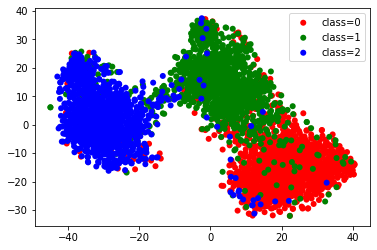

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
embeddings = test_embeddings.cpu().detach().numpy()
X_embedded = TSNE(n_components=2).fit_transform(embeddings)
# print(X_embedded)
fig, ax = plt.subplots()
for i, color in enumerate(["r", "g", "b"]):
    x = X_embedded[labels==i][:,0]
    y = X_embedded[labels==i][:,1]
    ax.scatter(x, y, c=color, label="class={}".format(i), alpha=1, edgecolors="none")
ax.legend()
plt.show()